<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/face-mask-detection/blob/main/Full_Face_Mask_Detection_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Mask Detection**

Program Machine Learning untuk mendeteksi pemakaian masker muka. Program dibuat menggunakan metode CNN dengan arsitektur MobileNetV2 dengan model pendeteksi wajah caffe model ResNet-10 dan MTCNN.

In [1]:
!nvidia-smi

Sun Jan 31 13:46:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Memeriksa CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


## Tahap Awal

In [3]:
# Melakukan cloning data
!git clone https://github.com/Soedirman-Machine-Learning/face-mask-detection.git

Cloning into 'face-mask-detection'...
remote: Enumerating objects: 4196, done.
remote: Total 4196 (delta 0), reused 0 (delta 0), pack-reused 4196
Receiving objects: 100% (4196/4196), 316.76 MiB | 44.03 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Checking out files: 100% (4087/4087), done.


In [4]:
# Berpindah ke folder face-mask-detection
%cd face-mask-detection/

# Memeriksa isi folder face-mask-detection
!ls

/content/face-mask-detection
'aplikasi android'
'berkas tugas akhir'
 dataset
 face-detector.zip
 Face_Mask_Detection_MobileNetV2.ipynb
 Face_Mask_Detection_MobileNetV2_with_MTCNN.ipynb
 Face_Mask_Detection_MobileNetV2_with_ResNet10.ipynb
 Face_Mask_Detection_VGG16Net.ipynb
 Face_Mask_Detection_VGG16Net_with_MTCNN.ipynb
 Face_Mask_Detection_VGG16Net_with_ResNet10.ipynb
 Full_Face_Mask_Detection_MobileNetV2.ipynb
 pengujian
 README.md


**Face-detector.zip** merupakan file untuk melakukan pengujian model dengan menggunakan res10_300x300_ssd_iter_140000.caffemodel dan deploy.prototxt untuk mendeteksi bagian wajah

In [5]:
# Melakukan unzip pada folder face-detector.zip
!unzip face-detector.zip

Archive:  face-detector.zip
  inflating: deploy.prototxt         
  inflating: example_img/ex01.jpg    
  inflating: example_img/ex02.jpg    
  inflating: example_img/ex03.jpg    
  inflating: example_img/ex04.jpg    
  inflating: example_img/ex05.jpg    
  inflating: example_img/ex06.jpg    
  inflating: example_img/ex07.jpg    
  inflating: example_img/ex08.jpg    
  inflating: example_img/ex09.jpg    
  inflating: example_img/ex10.jpg    
  inflating: res10_300x300_ssd_iter_140000.caffemodel  


## Mengimpor *Library*

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools
 
# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime
 
%load_ext autotime

time: 137 µs (started: 2021-01-31 13:46:19 +00:00)


In [7]:
# Memeriksa Versi TensorFlow
print(tf.__version__)

2.4.1
time: 2.21 ms (started: 2021-01-31 13:46:19 +00:00)


## *Preprocessing* Dataset

In [8]:
# Inisialisasi nilai Initial Learning Rate, berapa banyak Epoch pelatihan, dan Batch Size
INIT_LR = 1e-4
EPOCHS = 30
BS = 32
 
# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Menginput gambar...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
 
# Melakukan perulangan pada image paths
for imagePath in imagePaths:
 
    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Memuat input gambar (224x224) dan melakukan proses
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
 
    # Mengupdate data dan labels lists, berurutan
    data.append(image)
    labels.append(label)
 
# Mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
 
# Melakukan one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("Input gambar berhasil")

Menginput gambar...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Input gambar berhasil
time: 15.8 s (started: 2021-01-31 13:46:20 +00:00)


### Membuat objek ImageDataGenerator dan Data Augmentasi

In [9]:
# Mempartisi data ke dalam pelatihan dan pengujian (75% : 25%)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
 
# Membentuk training image generator untuk data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

time: 700 ms (started: 2021-01-31 13:46:36 +00:00)


## Membuat Model Jaringan CNN yang sudah dipelajari sebelumnya (*pre-trained convnets*)

In [10]:
# Arsitektur jaringan MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step
time: 6.39 s (started: 2021-01-31 13:46:37 +00:00)


### *Feature Extraction*

Menggunakan model *pre-trained* untuk ekstraksi fitur (*feature extraction*) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama.

In [11]:
baseModel.trainable = False
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Tahap Pembuatan Model

In [12]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)
 
# Perulangan pada seluruh base model
for layer in baseModel.layers:
    layer.trainable = False
 
# Persiapan kompilasi model
print("Mengkompilasi model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

Mengkompilasi model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________

### Melakukan Pelatihan Model

In [13]:
# Pelatihan model
print("Training head model...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training head model...
Epoch 1/30
95/95 [==============================] - 40s 333ms/step - loss: 0.6555 - accuracy: 0.6640 - val_loss: 0.1895 - val_accuracy: 0.9687
Epoch 2/30
95/95 [==============================] - 30s 318ms/step - loss: 0.1899 - accuracy: 0.9494 - val_loss: 0.1010 - val_accuracy: 0.9752
Epoch 3/30
95/95 [==============================] - 30s 320ms/step - loss: 0.1085 - accuracy: 0.9758 - val_loss: 0.0788 - val_accuracy: 0.9752
Epoch 4/30
95/95 [==============================] - 30s 319ms/step - loss: 0.0836 - accuracy: 0.9786 - val_loss: 0.0686 - val_accuracy: 0.9778
Epoch 5/30
95/95 [==============================] - 31s 322ms/step - loss: 0.0614 - accuracy: 0.9877 - val_loss: 0.0582 - val_accuracy: 0.9804
Epoch 6/30
95/95 [==============================] - 30s 320ms/step - loss: 0.0515 - accuracy: 0.9855 - val_loss: 0.0545 - val_accuracy: 0.9804
Epoch 7/30
95/95 [==============================] - 30s 320ms/step - loss: 0.0557 - accuracy: 0.9844 - val_loss: 0.0515

### Menampilkan Kurva Model Hasil Pelatihan

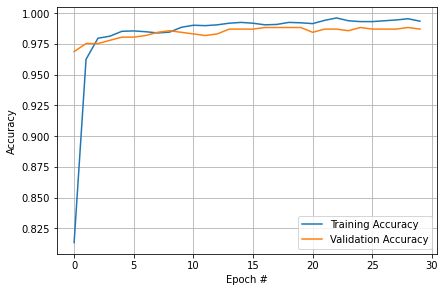

time: 216 ms (started: 2021-01-31 14:04:50 +00:00)


In [14]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.grid(zorder = 0)

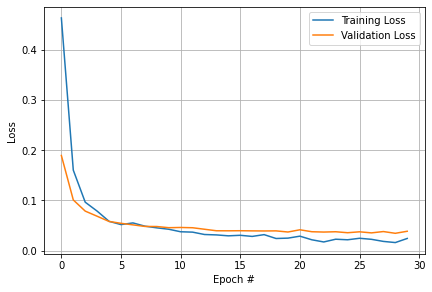

time: 146 ms (started: 2021-01-31 14:07:03 +00:00)


In [16]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.grid(zorder = 0)
plt.show()

### Evaluasi Jaringan

In [17]:
# Memeriksa matriks model
print(model.metrics_names)
# Evaluasi data test
print(model.evaluate(x= testX, y = testY))

['loss', 'accuracy']
24/24 [==============================] - 1s 50ms/step - loss: 0.0387 - accuracy: 0.9870
[0.038722239434719086, 0.9869621992111206]
time: 1.26 s (started: 2021-01-31 14:07:30 +00:00)


In [18]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(testY, axis=1)

# Label prediksi
YPred = model.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

[0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1
 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0
 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1
 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1
 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1
 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1
 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1
 0 1 0 1 0 1 1 1 0 0 1 1 

### Confusion Matrix

In [19]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue)) 
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

time: 2.48 ms (started: 2021-01-31 14:07:38 +00:00)


In [20]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[379,   4],
       [  6, 378]])

time: 4.56 ms (started: 2021-01-31 14:07:40 +00:00)


Text(0.5, 15.0, 'Prediction Label')

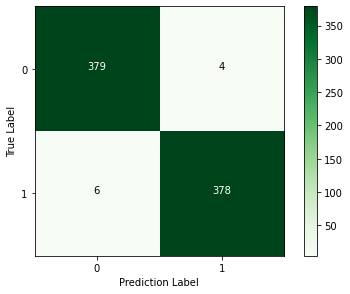

time: 208 ms (started: 2021-01-31 14:08:43 +00:00)


In [21]:
classes = [0, 1]

# Plotting confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
# plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Prediction Label')

Analisis mAP

In [22]:
# Berdasarkan confusion matrix
TP = true_pos = 378
TN = true_neg = 379
FP = false_pos = 4
FN = false_neg = 6

time: 1.36 ms (started: 2021-01-31 14:09:27 +00:00)


In [23]:
results = {}

# Akurasi
metric = "Akurasi"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Recall
metric = "Recall"
results[metric] = TP / (TP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Presisi
metric = "Presisi"
results[metric] = TP / (TP + FP)
print(f"{metric} = {results[metric]: .3f}")

# Nilai F1
metric = "F1"
results[metric] = 2 / (1 / results["Presisi"] + 1 / results["Recall"])
print(f"{metric} = {results[metric]: .3f}")

Akurasi =  0.987
Recall =  0.984
Presisi =  0.990
F1 =  0.987
time: 7.9 ms (started: 2021-01-31 14:09:29 +00:00)


In [24]:
# Membuat prediksi dari pengujian
predIdxs = model.predict(testX, batch_size=BS)
 
# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)
 
# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       383
without_mask       0.99      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

time: 944 ms (started: 2021-01-31 14:09:34 +00:00)


## Menyimpan dan Konversi Model ke ".tflite"
Menyimpan model menggunakan tf.saved_model/save dan kemudian mengkonversi model tersimpan ke format yang kompatibel tf lite.

In [25]:
export_dir='saved_model/1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets
time: 14.8 s (started: 2021-01-31 14:09:39 +00:00)


In [26]:
# Mengkonvert model ke format tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

time: 7.5 s (started: 2021-01-31 14:09:54 +00:00)


In [27]:
# Menyimpan model
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

9504936

time: 10.6 ms (started: 2021-01-31 14:10:01 +00:00)


In [28]:
# Memuat model dan mengalokasikan ke tensor
interpreter = tf.lite.Interpreter(model_content = tflite_model)
interpreter.allocate_tensors()

# Mendapatkan input dan ouput tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

print(input_details)
print(output_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 181, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
time: 29.6 ms (started: 2021-01-31 14:10:01 +00:00)


## Pengujian Model dengan SSD ResNet10
Model diujikan pada gambar dan secara real-time dengan menggunakan res10_300x300_ssd_iter_14000.caffemodel dan deploy.prototxt yang digunakan untuk mendeteksi wajah.

### Pengujian Model pada Gambar


In [29]:
import cv2
from google.colab.patches import cv2_imshow

time: 4.14 ms (started: 2021-01-31 14:10:37 +00:00)


Mendeteksi wajah...


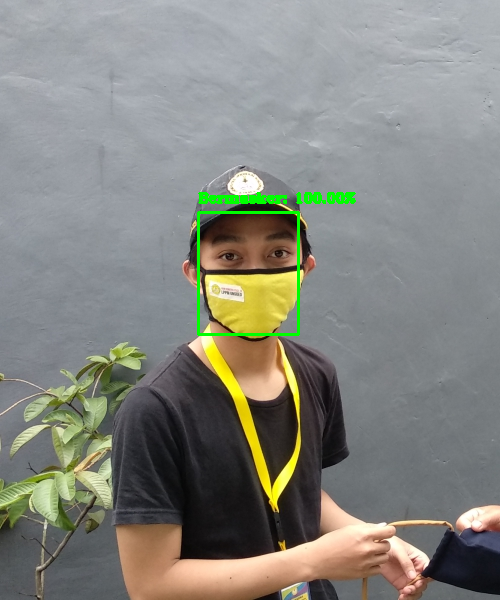

-1

time: 832 ms (started: 2021-01-31 14:10:49 +00:00)


In [30]:
image = cv2.imread('/content/face-mask-detection/example_img/ex03.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

net=cv2.dnn.readNet('/content/face-mask-detection/deploy.prototxt','/content/face-mask-detection/res10_300x300_ssd_iter_140000.caffemodel')

# Melewatkan blob melalui jaringan dan mendapatkan deteksi wajah
print("Mendeteksi wajah...")
net.setInput(blob)
detections = net.forward()

for i in range(0, detections.shape[2]):
	# ekstrak keyakinan (yaitu, probabilitas) yang terkait dengan deteksi
	confidence = detections[0, 0, i, 2]

	if confidence > 0.5:
		# Menghitung koordinat (x, y) dari kotak pembatas untuk objek
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# Memastikan kotak pembatas berada dalam dimensi bingkai
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
    # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# Membaca wajah dengan model
		(mask, withoutMask) = model.predict(face)[0]

		# Menggunakan masker hijau, tidak bermasker merah
		label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
		color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

		# Probabilitas hasil deteksi
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# Menampilkan hasil dengan label dan kotak
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_TRIPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# Menampilkan output
cv2_imshow(image)
cv2.waitKey(0)

### Pengujian Deteksi Perframe Capture

In [31]:
# Mengimport lib
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import pickle
import cv2
import os
 
def detect_and_predict_mask(frame, faceNet, maskNet):
    # Membuat dimensi kotak deteksi
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
 
    # Melewatkan blob dan mendeteksi wajah
    faceNet.setInput(blob)
    detections = faceNet.forward()
 
    # Inisialisasi
    faces = []
    locs = []
    preds = []
 
    for i in range(0, detections.shape[2]):
        # ekstrak keyakinan (yaitu, probabilitas) yang terkait dengan deteksi
        confidence = detections[0, 0, i, 2]
 
        if confidence > 0.5:
            # Menghitung koordinat (x, y) dari kotak pembatas untuk objek
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
 
            # Memastikan kotak pembatas berada dalam dimensi bingkai
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
 
            # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
            # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
 
            # Menambahkan kotak deteksi
            faces.append(face)
            locs.append((startX, startY, endX, endY))
 
    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)
 
    return (locs, preds)
 
faceNet=cv2.dnn.readNet('/content/face-mask-detection/deploy.prototxt','/content/face-mask-detection/res10_300x300_ssd_iter_140000.caffemodel')

time: 49.9 ms (started: 2021-01-31 14:10:59 +00:00)


In [32]:
import base64
import html
import io
import time
 
from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2
 
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Ketika selesai, klik disini atau pada video untuk berhenti dari demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
 
  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

time: 27.1 ms (started: 2021-01-31 14:11:04 +00:00)


In [33]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)
 
    return image_array

time: 3.05 ms (started: 2021-01-31 14:11:11 +00:00)


In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''
start_time = time.time()
frame_count = 0 

from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
    
  image = js_reply_to_image(js_reply)
  frame_count += 1 # for fps

	# Mengambil frame dari aliran video berulir dan 
  # ukurannya maksimum lebar 400 pixel
  frame = image
  v=True
  if v == True:

    frame = imutils.resize(frame, width=400)

	# Mendeteksi bermasker atau tidak
    (locs, preds) = detect_and_predict_mask(frame, faceNet, model)
    for (box, pred) in zip(locs, preds):


		# Membuka kotak dan prediksi
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

		# Menggunakan masker hijau, tidak bermasker merah
      label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
      color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

		# Probabilitas pada label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# Menampilkan hasil dengan label dan kotak dari frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    # Menampilkan FPS
      elapsed_time = time.time() - start_time
      fps = frame_count / elapsed_time
      cv2.putText(img=frame, text='FPS : ' + str(round(fps,2)), org=(10, 20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255), thickness=1)

	# Menampilkan ouput
      cv2_imshow(frame)

### Pengujian Streaming Video

In [35]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

time: 2.35 ms (started: 2021-01-31 14:12:29 +00:00)


In [36]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

time: 12.9 ms (started: 2021-01-31 14:12:32 +00:00)


In [37]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

time: 24.9 ms (started: 2021-01-31 14:12:37 +00:00)


In [38]:
 def detect_and_predict_mask(img, faceNet, maskNet):
    # Membuat dimensi kotak deteksi
    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
 
    # Melewatkan blob dan mendeteksi wajah
    faceNet.setInput(blob)
    detections = faceNet.forward()
 
    # Inisialisasi
    faces = []
    locs = []
    preds = []
 
    for i in range(0, detections.shape[2]):
        # ekstrak keyakinan (yaitu, probabilitas) yang terkait dengan deteksi
        confidence = detections[0, 0, i, 2]
 
        if confidence > 0.5:
            # Menghitung koordinat (x, y) dari kotak pembatas untuk objek
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
 
            # Memastikan kotak pembatas berada dalam dimensi bingkai
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
 
            # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
            # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
 
            # Menambahkan kotak deteksi
            faces.append(face)
            locs.append((startX, startY, endX, endY))
 
    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)
 
    return (locs, preds)
 
faceNet=cv2.dnn.readNet('/content/face-mask-detection/deploy.prototxt','/content/face-mask-detection/res10_300x300_ssd_iter_140000.caffemodel')

time: 42.7 ms (started: 2021-01-31 14:12:43 +00:00)


In [39]:
# Memulai streaming video dari webcam
video_stream()
# Label untuk video
label_html = 'Capturing...'
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Mengkonvert JS response ke OpenCV Image
    img = js_to_image(js_reply["img"])

    # Membuat transparan overlay untuk bounding box
    bbox_array = np.zeros([512,512,4], dtype=np.uint8)

    # Mendeteksi bermasker atau tidak
    (locs, preds) = detect_and_predict_mask(img, faceNet, model)
    for (box, pred) in zip(locs, preds):

		# Membuka kotak dan prediksi
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

		# Menggunakan masker hijau, tidak bermasker merah
      label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
      color = (0, 255, 0) if label == "Bermasker" else (255, 0, 0)

		# Probabilitas pada label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# Menampilkan hasil dengan label dan kotak dari frame
      bbox_array=cv2.putText(bbox_array, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      bbox_array=cv2.rectangle(bbox_array, (startX, startY), (endX, endY), color, 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    # Mengkonversi overlay bbox ke dalam bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
 
    # Mengupdate bbox ke pada frame selanjutnya untuk mendapat overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

time: 26.1 s (started: 2021-01-31 14:12:47 +00:00)


## Pengujian Model dengan MTCNN
Model diujikan pada gambar dan secara real-time dengan menggunakan MTCNN yang digunakan untuk mendeteksi wajah.

In [40]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 16.8MB/s 
time: 2.4 s (started: 2021-01-31 14:13:20 +00:00)


### Pengujian Model pada Gambar

In [41]:
from mtcnn import MTCNN
import cv2
from google.colab.patches import cv2_imshow

time: 40.9 ms (started: 2021-01-31 14:13:24 +00:00)


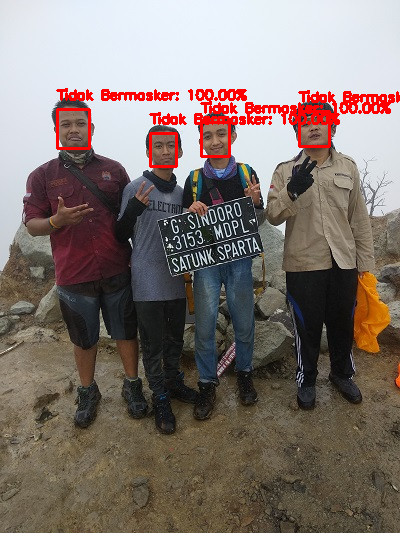

-1

time: 1.58 s (started: 2021-01-31 14:13:28 +00:00)


In [42]:
detector = MTCNN()
image = cv2.imread('/content/face-mask-detection/example_img/ex10.jpg', cv2.COLOR_BGR2RGB)
faces = detector.detect_faces(image)
for result in faces:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h
    
    # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
    # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
    face = image[y:y1, x:x1]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)    

    # Membaca wajah dengan model
    (mask, withoutMask) = model.predict(face)[0]

    # Menggunakan masker hijau, tidak bermasker merah
    label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
    color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

		# Probabilitas hasil deteksi
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

    # Menampilkan hasil dengan label dan kotak
    cv2.putText(image, label, (x, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (x, y), (x1, y1), color, 2)

# Menampilkan output
cv2_imshow(image)
cv2.waitKey(0)

### Pengujian Deteksi Perframe Capture

In [43]:
# Mengimport lib
from mtcnn import MTCNN
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from IPython.display import display, Javascript
from google.colab.output import eval_js
from PIL import Image
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import base64
import html
import io
import time
import pickle

time: 7.35 ms (started: 2021-01-31 14:13:40 +00:00)


In [45]:
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Ketika selesai, klik disini atau pada video untuk berhenti dari demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
 
  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

time: 25.2 ms (started: 2021-01-31 14:14:06 +00:00)


In [46]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)
 
    return image_array

time: 3.28 ms (started: 2021-01-31 14:14:12 +00:00)


In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''

start_time = time.time()
frame_count = 0 

# Menginisialisasi MTCNN
detector = MTCNN()

from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
    
  image = js_reply_to_image(js_reply)
  frame_count += 1 # untuk fps

	# Mengambil frame dari aliran video berulir dan 
  # ukurannya maksimum lebar 400 pixel
  frame = image
  v=True
  if v == True:

    frame = imutils.resize(frame, width=400)

    faces = detector.detect_faces(frame)
    faces_list = []
    preds = []
    for result in faces:
      x, y, w, h = result['box']
      x1, y1 = x + w, y + h

      # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
      # dan mengubah ukurannya menjadi 224x224, dan lalu pre-prosess
      face = image[y:y1, x:x1]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (224, 224))
      face = img_to_array(face)
      face = preprocess_input(face)
      face = np.expand_dims(face, axis=0)
     
      faces_list.append(face)
      
      if len(faces_list) > 0:
        preds = model.predict(faces_list)
    
      # Mendeteksi bermasker atau tidak
      for pred in preds:
        (mask, withoutMask) = pred

	  	# Menggunakan masker hijau, tidak bermasker merah
      label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
      color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

	  	# Probabilitas pada label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

	  	# Menampilkan hasil dengan label dan kotak dari frame
      frame=cv2.putText(frame, label, (x, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (x, y), (x1, y1), color, 2)

      # Menampilkan FPS
      elapsed_time = time.time() - start_time
      fps = frame_count / elapsed_time
      cv2.putText(img=frame, text='FPS : ' + str(round(fps,2)), org=(10, 20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255), thickness=1)

	# Menampilkan ouput
      cv2_imshow(frame)

### Pengujian Streaming Video

In [49]:
# import dependencies
from mtcnn import MTCNN
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

time: 2.9 ms (started: 2021-01-31 14:16:16 +00:00)


In [50]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

time: 7.97 ms (started: 2021-01-31 14:16:19 +00:00)


In [51]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

time: 24.5 ms (started: 2021-01-31 14:16:25 +00:00)


In [ ]:
# Memulai streaming video dari webcam
video_stream()
# Label untuk video
label_html = 'Capturing...'
bbox = ''
count = 0 
# Menginisialisasi MTCNN
detector = MTCNN()

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Mengkonvert JS response ke OpenCV Image
    img = js_to_image(js_reply["img"])
    
    # Membuat transparan overlay untuk bounding box
    bbox_array = np.zeros([512,512,4], dtype=np.uint8)

    faces = detector.detect_faces(img)
    faces_list = []
    preds = []

    for result in faces:
      x, y, w, h = result['box']
      x1, y1 = x + w, y + h
      
      # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
      # dan mengubah ukurannya menjadi 224x224, dan lalu pre-prosess
      face = image[y:y1, x:x1]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (224, 224))
      face = img_to_array(face)
      face = preprocess_input(face)
      face = np.expand_dims(face, axis=0)
     
      faces_list.append(face)
      
      if len(faces_list) > 0:
        preds = model.predict(faces_list)
    
      # Mendeteksi bermasker atau tidak
      for pred in preds:
        (mask, withoutMask) = pred

		  # Menggunakan masker hijau, tidak bermasker merah
      label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
      color = (0, 255, 0) if label == "Bermasker" else (255, 0, 0)

		  # Probabilitas pada label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		  # Menampilkan hasil dengan label dan kotak dari frame
      bbox_array=cv2.putText(bbox_array, label, (x, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      bbox_array=cv2.rectangle(bbox_array, (x, y), (x1, y1), color, 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    # Mengkonversi overlay bbox ke dalam bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
 
    # Mengupdate bbox ke pada frame selanjutnya untuk mendapat overlay
    bbox = bbox_bytes